## Import the libraries for viz, data wrangling and ML

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import PIL.Image
import tarfile
import tensorflow as tf

from google.cloud import storage


## Ingest the data from Google Cloud Storage

### Initialize a Google storage object

In [2]:
client = storage.Client()

### Download to local folder

In [3]:
bucket_name = "christmas-sweaters"
blob_name = "sweaters-live.tgz"

bucket = client.get_bucket(bucket_name)
blob = bucket.get_blob(blob_name)
blob.download_to_filename(blob_name)

print("Downloaded blob {} to {}.".format(blob.name, blob_name))

Downloaded blob sweaters-live.tgz to sweaters-live.tgz.


### Extract TAR to **Keras** dataset folder

In [4]:
data_dir = "/home/jupyter/.keras/datasets/sweaters-live"

file = tarfile.open(blob_name)
file.extractall(data_dir)
file.close()


### Set uniform size of pictures --> 180x180 pixels

In [5]:
batch_size = 32
img_height = 180
img_width = 180

### Use **Keras** utils to create Train and Validate Data Sets

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 88 files belonging to 2 classes.
Using 71 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 88 files belonging to 2 classes.
Using 17 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['cute', 'goofy']


### Preview the images

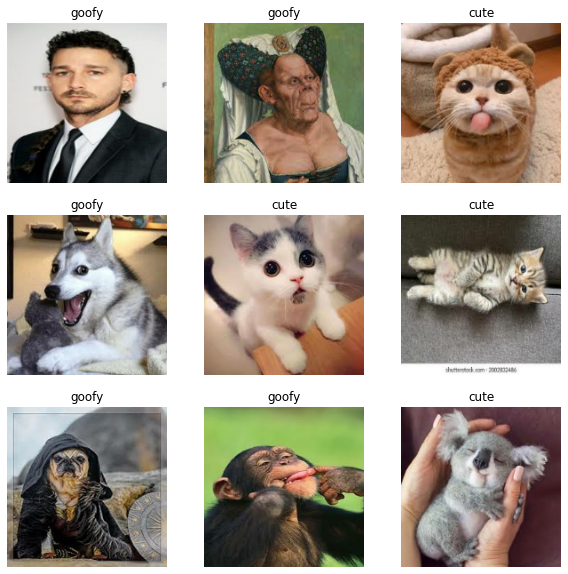

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Normalize the image vectors

In [12]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


### Create and compile model

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [16]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

### A function to plot loss

In [17]:

def plot_loss(history):
  plt.plot(history.history['loss'],
           label='loss')
  plt.plot(history.history['val_loss'],
           label='val_loss')
  plt.ylim([0, 2])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Drinks]')
  plt.legend()
  plt.grid(True)

### Fit the model

In [18]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=9
)

Epoch 1/9
3/3 [==============================] - 2s 523ms/step - loss: 0.7304 - accuracy: 0.5211 - val_loss: 0.6543 - val_accuracy: 0.7059
Epoch 2/9
3/3 [==============================] - 2s 455ms/step - loss: 0.7640 - accuracy: 0.5070 - val_loss: 0.6617 - val_accuracy: 0.8235
Epoch 3/9
3/3 [==============================] - 2s 441ms/step - loss: 0.6648 - accuracy: 0.6479 - val_loss: 0.5779 - val_accuracy: 0.7059
Epoch 4/9
3/3 [==============================] - 2s 443ms/step - loss: 0.6507 - accuracy: 0.5775 - val_loss: 0.6079 - val_accuracy: 0.8824
Epoch 5/9
3/3 [==============================] - 1s 434ms/step - loss: 0.5930 - accuracy: 0.6761 - val_loss: 0.5299 - val_accuracy: 0.8824
Epoch 6/9
3/3 [==============================] - 2s 443ms/step - loss: 0.5718 - accuracy: 0.6901 - val_loss: 0.5848 - val_accuracy: 0.7647
Epoch 7/9
3/3 [==============================] - 2s 449ms/step - loss: 0.4889 - accuracy: 0.7746 - val_loss: 0.5458 - val_accuracy: 0.7647
Epoch 8/9
3/3 [============

### Plot the loss

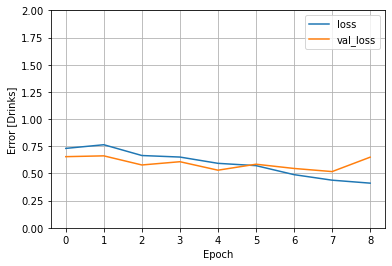

In [19]:
plot_loss(history)